In [1]:
"""
First run tsne_encoder.py until the visualizations look good, and then set tsne_cache path to that experiment dir.
"""


import time
import numpy as np
import os
import matplotlib
import mlflow

# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import argparse
import os
import _pickle
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import skimage.io as skio
import skimage.transform as skts


from matplotlib.colors import ListedColormap


def retry(f):
    while True:
        try:
            return f()
        except:
            time.sleep(1)
            print("Retrying mlflow.")


def setup_mlflow():
    os.environ["MLFLOW_TRACKING_USERNAME"] = "exp-01.mlflow-yang.ericst"
    os.environ["MLFLOW_TRACKING_PASSWORD"] = "parolaeric"
    remote_server_uri = "https://exp-01.mlflow-yang.inf.ethz.ch"
    retry(lambda: mlflow.set_tracking_uri(remote_server_uri))


def plot_tsne(exp_path, uc, ax, color_space=None, n_color_max=20, cat2color=None):
    X_embedded = None
    ALL_Y = None
    Cat2Y = None
    for (dirpath, dirnames, filenames) in os.walk(exp_path):
        for filename in filenames:
            if ("embedded_UC%i" % uc) in filename:
                X_embedded = np.load(os.path.join(exp_path, filename))
            elif ("selectedY_UC%i" % uc) in filename:
                ALL_Y = np.load(os.path.join(exp_path, filename))
            elif ("cat2y_UC%i" % uc) in filename:
                with open(os.path.join(exp_path, filename), "rb") as fp:
                    Cat2Y = _pickle.load(fp)
    if any([X_embedded is None, ALL_Y is None, Cat2Y is None]):
        raise FileNotFoundError("Missing some files from exp dir: %s" % exp_path)
    else:
        Y2Cat = dict([(v, k) for k, v in Cat2Y.items()])
        cat_labels = [Y2Cat[y] for y in ALL_Y]

        if color_space is None:
            assert cat2color is None
            color_space = sns.color_palette("hls", n_color_max)
            cat2color = {}
            i = 0
            for y, cat in Y2Cat.items():
                cat2color[cat] = color_space[i]
                i += 1
            this_color_list = [c for cat, c in cat2color.items()]
            this_cmap = ListedColormap(this_color_list)
        else:
            assert cat2color is not None
            n_used_colors = len(list(cat2color.values()))
            this_color_list = []
            for y, cat in Y2Cat.items():
                if cat in cat2color.keys():
                    this_color_list.append(cat2color[cat])
                else:
                    # new category
                    this_color_list.append(color_space[n_used_colors])
                    cat2color[cat] = color_space[n_used_colors]
                    n_used_colors += 1
            this_cmap = ListedColormap(this_color_list)

        df = pd.DataFrame(
            {"x": X_embedded[:, 0], "y": X_embedded[:, 1], "Dataset": cat_labels}
        )
        sns.scatterplot(
            "x",
            "y",
            hue="Dataset",
            s=1.0,
            data=df,
            ax=ax,
            linewidth=0,
            palette=cat2color,
        )
        ax.set_axis_off()
        ax.legend_.remove()
        # ax.legend(loc='upper right')
    return ax, color_space, cat2color


def plot_image(file_path, ax, uc):
    img = skio.imread(file_path)
    long_edge = max(img.shape[0], img.shape[1])
    img = skts.resize(img, (long_edge, long_edge))
    if len(img.shape) > 2:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap="gray")
    ax.set_axis_off()
    ax.annotate(
        "Usecase %d" % uc,
        xy=(0.0, 0.5),
        xycoords="axes fraction",
        fontsize=5,
        xytext=(-5, 12),
        textcoords="offset points",
        ha="center",
        va="baseline",
        rotation=90,
    )
    # ax.set_ylabel("Usecase %d" % uc)
    return ax


def load_reto(d1, uc, pretrained: bool = False):
    if d1 == "NIHCC":
        D_id = "nih_id"
        D_ood = {
            1: "uc1_and_mura",
            2: "pc_for_nih",
            3: "nih_ood",
        }[uc]
    elif d1 == "PAD":
        D_id = "pc_id"
        D_ood = {
            1: "uc1_and_mura",
            2: "pc_uc2",
            3: "pc_uc3",
        }[uc]
    elif d1 == "DRD":
        D_id = "drd"
        D_ood = {
            1: "uc1_rgb",
            2: "drimdb",
            3: "riga",
        }[uc]
    else:
        assert False, f"Unknown dataset: {d1}"

    exp_name = f"{D_id}_vs_{D_ood}"

    exp = retry(lambda: mlflow.get_experiment_by_name(exp_name))
    runs = retry(lambda: mlflow.list_run_infos(exp.experiment_id))

    stats = {
        "auroc": [],
        "aupr": [],
    }

    for run_info in runs:
        run = retry(lambda: mlflow.get_run(run_info.run_id))
        if run.data.params.get("ensemble_type") != "assign_one_label":
            continue

        if run.data.params.get("use_pretrained_model") != str(pretrained):
            continue

        if run.data.params.get("model_arch") != "densenet":
            continue

        if run.data.tags.get("goal") != "final":
            continue

        metrics = run.data.metrics

        for k, v in {
            "auroc": metrics["heur_auroc_avg_diff"],
            "aupr": metrics["heur_aupr_avg_diff"],
        }.items():
            stats[k].append(v)

    for k, v in stats.items():
        assert len(v) > 0, f"Could not find any stats for {k}."

    return {k: np.mean(v) for k, v in stats.items()}


def get_results(
    exp_path,
    d1,
    uc,
):
    csv_data = np.load(os.path.join(exp_path, "data_UC%d_%s.npy" % (uc, d1)))
    assert os.path.isfile(os.path.join(exp_path, "headers_UC%d_%s.pkl" % (uc, d1)))
    with open(os.path.join(exp_path, "headers_UC%d_%s.pkl" % (uc, d1)), "rb") as fp:
        csv_headers = _pickle.load(fp)

    csv_headers[0].append("RETO")
    csv_headers[0].append("RETO(pretrained)")
    method_handles = csv_headers[0]

    weights = csv_data[0]
    uc_roc = csv_data[2] * 100
    uc_prc = csv_data[3] * 100

    if len(uc_roc.shape) == 3:
        rocm = np.average(uc_roc, axis=(1, 2), weights=weights)
    else:
        new_weights = np.zeros_like(uc_roc)
        for i in range((uc_roc.shape[0])):
            for j in range((uc_roc.shape[1])):
                for k in range((uc_roc.shape[2])):
                    n = int(weights[i, j, k, 0])
                    for l in range(n):
                        new_weights[i, j, k, l] = 1
        rocm = np.average(uc_roc, axis=(1, 2, 3), weights=new_weights)

    reto_data = load_reto(d1, uc, pretrained=False)

    rocm = np.append(rocm, reto_data["auroc"] * 100)

    pretrained_reto_data = load_reto(d1, uc, pretrained=True)
    rocm = np.append(rocm, pretrained_reto_data["auroc"] * 100)

    ret = {}
    for i in range(len(method_handles)):
        ret[method_handles[i]] = rocm[i]
    return ret


setup_mlflow()
PREVIEW_DOUBLE = True

acc_results = {}
for d in ["PAD", "NIHCC", "DRD"]:
    for uc in [1, 2, 3]:
        exp_path = {
            "NIHCC": "nih_proced_res_mode1",
            "PAD": "pad_proced_res_mode1",
            "DRD": "drd_proced_res_mode1",
        }[d]
        cur_results = get_results(exp_path, d, uc)

        for m, a in cur_results.items():
            l = acc_results.get(m, [])
            l.append(a)
            acc_results[m] = l

results = {m: np.mean(l) for m, l in acc_results.items()}


[('12Layer-VAE-BCE', 83.45291996801282),
 ('binclass/0', 84.09117856414915),
 ('12Layer-AE-MSE', 84.74220671440462),
 ('RETO(pretrained)', 89.26175628621762),
 ('RETO', 91.04579221047366)]

In [12]:
import plotly.express as px
import plotly.graph_objects as go

In [86]:
alias = {
    "prob_threshold/0": "Prob. threshold",
    "score_svm/0": "Score SVM",
    "binclass/0": "Binary classifier",
    "odin/0": "ODIN",
    "Maha": "Mahalanobis",
    "Maha1layer": "Single layer Maha.",
    "svknn": "Feature knn",
    "12Layer-AE-BCE": "Reconst. AEBCE",
    "12Layer-AE-MSE": "AE Reconst. MSE",
    "12Layer-VAE-MSE": "Reconst. VAEMSE",
    "12Layer-VAE-BCE": "VAE Reconst. BCE",
    "ALI_reconst/0": "Reconst. ALI",
    "knn/1": "KNN-1",
    "knn/8": "kNN",
    "bceaeknn/8": "AEBCE-KNN-8",
    "vaebceaeknn/8": "VAEBCE-KNN-8",
    "mseaeknn/8": "AEMSE-KNN-8",
    "vaemseaeknn/8": "VAEMSE-KNN-8",
    "bceaeknn/1": "AEBCE-KNN-1",
    "vaebceaeknn/1": "VAEBCE-KNN-1",
    "mseaeknn/1": "AEMSE-KNN-1",
    "vaemseaeknn/1": "VAEMSE-KNN-1",
    "RETO": "RETO (rand init)",
    "RETO(pretrained)": "RETO (pretrained)",
}

In [87]:
top = []
for m in [
    'RETO',
    'RETO(pretrained)',
    'Maha',
    'knn/8',
    '12Layer-AE-MSE',
    '12Layer-VAE-BCE',
]:
    top.append((m, results[m]))
    
top = sorted(top, key=lambda x: x[1])
top

[('Maha', 80.39585112944047),
 ('knn/8', 82.43727142189137),
 ('12Layer-VAE-BCE', 83.45291996801282),
 ('12Layer-AE-MSE', 84.74220671440462),
 ('RETO(pretrained)', 89.26175628621762),
 ('RETO', 91.04579221047366)]

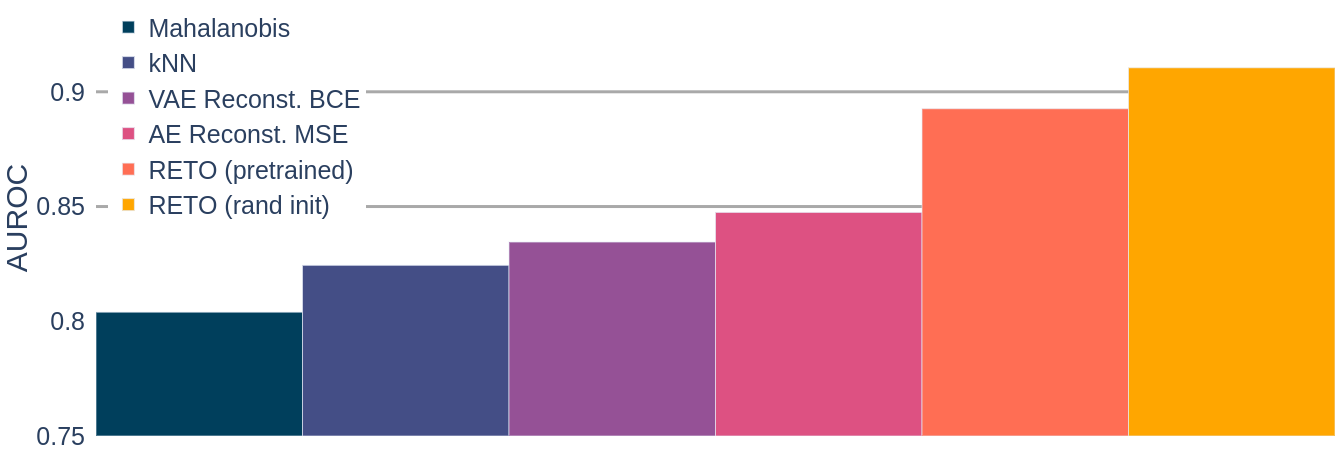

In [100]:
colors = [
    "#003f5c",
    "#444e86",
    "#955196",
    "#dd5182",
    "#ff6e54",
    "#ffa600",
]

bars = []

base = 0.75

for im, (m, auroc) in enumerate(top):
    nice_method_name = alias[m]
    
    bar = go.Bar(
        name=nice_method_name,
        x=[""],
        y=[auroc / 100 - base],
        marker_color=colors[im],
        base=base,
    )
    bars.append(bar)


fig = go.Figure(data=bars)


fig.update_layout(
    margin=dict(
        l=0, r=0, t=0, b=0,
        pad=10
    ),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0.75,
        dtick = 0.05
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    #paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis_showgrid=True,
    yaxis_gridwidth=3,
    yaxis_gridcolor="darkgray",
    font_size=25,
    yaxis_title="AUROC",
)
fig.update_xaxes(range=[-0.4, 0.4])

fig.update_yaxes(range=[0.75, 0.94])


fig.show()